# Training

I have successfully been able to build a sort of data set for this model. Now I want to try training on my data.

In [2]:
import sys
!{sys.executable} -m pip install cupy-cuda11x

ERROR: Could not find a version that satisfies the requirement cupy-cuda11x (from versions: none)
ERROR: No matching distribution found for cupy-cuda11x


In [3]:
import pandas as pd
import numpy as np

# first we need to read the data in

data_name = 'dataset.csv'

all_data = pd.read_csv(data_name)
all_data

,netIncomePerShare,freeCashFlowPerShare,peRatio,priceToSalesRatio,pbRatio,debtToEquity,dividendYield,payoutRatio,roe,ticker,label
0,0.037304,0.081930,68.692936,16.198334,3.792215,1.051065,0.000404,0.111111,0.013801,CMCSA,0.0
1,0.366850,0.337912,8.135137,18.134324,3.515821,0.918390,0.000015,0.000485,0.108044,CMCSA,1.0
2,0.132520,0.173255,18.516105,6.586352,1.420348,0.761143,0.003187,0.236057,0.019177,CMCSA,0.0
3,0.071330,0.172091,29.580969,5.532793,1.205178,0.746057,0.003692,0.436893,0.010185,CMCSA,0.0
4,0.133795,0.211265,12.743329,4.438462,0.957572,0.715781,0.004574,0.233161,0.018786,CMCSA,0.0
...,...,...,...,...,...,...,...,...,...,...,...
136443,0.600000,1.265324,3.083333,3.700391,0.383926,0.001104,0.000011,0.000135,0.031129,SNGR.L,0.0
136444,0.400000,0.948329,4.281250,3.332726,0.322385,0.001067,0.256648,4.395096,0.018825,SNGR.L,0.0
136445,0.792549,1.878183,2.160751,2.286619,0.339581,0.001007,0.000037,0.000320,0.039290,SNGR.L,1.0
136446,1.200000,1.440450,1.614583,2.256612,0.362996,0.000928,0.000067,0.000433,0.056206,SNGR.L,1.0


In [4]:
# We may need to consolidate larger values by taking the log of our data before
# trying to pull out outliers

def log_data(data, cols_to_log=None, feature_size=9):
    cols_for_logging = data.columns[:feature_size]

    if cols_to_log:
        cols_for_logging = cols_to_log

    for col in cols_for_logging:
        # we have to offset all data by the absolute value of it if its negative
        info = data[col].describe()
        if info['min'] < 0:
            data[col] = data[col] + np.abs(info['min']) + 1

        data[col] = np.log(data[col])
    
    return data

all_data = log_data(all_data)
all_data

,netIncomePerShare,freeCashFlowPerShare,peRatio,priceToSalesRatio,pbRatio,debtToEquity,dividendYield,payoutRatio,roe,ticker,label
0,9.789873,14.7112,18.518706,11.567448,8.644031,11.667213,-7.813165,9.288283,5.373945,CMCSA,0.0
1,9.789891,14.7112,18.518705,11.567466,8.643982,11.667212,-11.112948,9.288273,5.374382,CMCSA,1.0
2,9.789878,14.7112,18.518705,11.567357,8.643613,11.667211,-5.748617,9.288295,5.373970,CMCSA,0.0
3,9.789875,14.7112,18.518705,11.567347,8.643575,11.667211,-5.601492,9.288314,5.373929,CMCSA,0.0
4,9.789878,14.7112,18.518705,11.567337,8.643531,11.667210,-5.387330,9.288295,5.373969,CMCSA,0.0
...,...,...,...,...,...,...,...,...,...,...,...
136443,9.789904,14.7112,18.518705,11.567330,8.643430,11.667204,-11.419512,9.288273,5.374026,SNGR.L,0.0
136444,9.789893,14.7112,18.518705,11.567326,8.643419,11.667204,-1.360050,9.288680,5.373969,SNGR.L,0.0
136445,9.789915,14.7112,18.518705,11.567316,8.643422,11.667204,-10.202989,9.288273,5.374064,SNGR.L,1.0
136446,9.789938,14.7112,18.518705,11.567316,8.643426,11.667204,-9.609178,9.288273,5.374142,SNGR.L,1.0


In [5]:
# We need to attempt to handle outliers in our data.
# this removes outliers based on the interquartile range
def remove_outliers_iqr(data, iqr_mod=1.5, feature_size=9):
    cols_for_trimming = data.columns[:feature_size]

    # we need to go through each feature and check the inter quartile ranges.
    # we'll drop values with info outside of the multiplier on the range we
    # provided
    print('Old length: {:d}'.format(len(data)))
    for col in cols_for_trimming:
        info = data[col].describe()
        range_add = (info['75%'] - info['25%']) * iqr_mod
        data = data[(data[col] >= info['25%'] - range_add)]
        data = data[(data[col] <= info['75%'] + range_add)]
    print('New length: {:d}'.format(len(data)))

    return data


# it might be useful to try making one for the z-score, but I don't know
# if our distribution is normalized.

all_data = remove_outliers_iqr(all_data, 5)

Index(['netIncomePerShare', 'freeCashFlowPerShare', 'peRatio',
       'priceToSalesRatio', 'pbRatio', 'debtToEquity', 'dividendYield',
       'payoutRatio', 'roe'],
      dtype='object')
Old length: 136448
New length: 108152


In [8]:
# there are a couple of preliminary steps we need to take. 

# 1) handle outliers
# 2) normalize all of the data (0 to 1)
# 3) separate testing and training sets


def normalize_data(data, feature_size=9):
    cols_for_normalization = data.columns[:feature_size]
    
    for col in cols_for_normalization:
        max = data[col].max()
        min = data[col].min()
        print(max)

        data[col] = (data[col] - min) / (max - min)

normalize_data(all_data)

9.790051250741316
14.711201294824106
18.518706486141376
11.568015320151485
8.645939524629462
11.667243503526587
3.6137942376991385
9.288617587790053
5.374716997680058


In [93]:
# separate training and test sets

def separate_sets(data, prop_test, prop_train=0, feature_size=9):

    # we need to drop superfluous info like tickers
    data = data.drop(['ticker'], axis=1)

    if prop_train == 0 or prop_train + prop_test > 1:
        prop_train = 1 - prop_test
    
    # we find out the ratio to take from the remaining portion
    prop_train = (1 - prop_test) / prop_train
    if prop_train > 1:
        prop_train = 1

    test_set = data.sample(frac=prop_test)
    data = data.drop(test_set.index)
    train_set = data.sample(frac=prop_train)

    test_f = np.array(test_set[test_set.columns[:feature_size]])
    test_l = np.concatenate(np.array(test_set[test_set.columns[feature_size:]]))

    train_f = np.array(train_set[train_set.columns[:feature_size]])
    train_l = np.concatenate(np.array(train_set[train_set.columns[feature_size:]]))

    return (test_f, test_l, train_f, train_l)

test_features, test_labels, train_features, train_labels = separate_sets(all_data, .2)

train_labels

array([0., 0., 1., ..., 1., 1., 0.])

# Building the Model

Now that we have theoretcially written everything needed to properly prep the data, we need to choose a model to implement. I think for now I will attempt to start off with basic logistic regression and increase complexity as needed.

This means we will need a: 
* predictor
* loss function
* derivative of loss function
* gradient descent function

In [22]:
def make_prediction(weights, features):
    return 1 / (1 + np.exp(-np.dot(weights[1:], features) - weights[0]))

make_prediction([-.5] * 10, train_features[0])

0.06029810285677426

# The Loss Functions

I didn't actually remember the math behind this so I looked up a good logistic regression algorithm loss and gradient of the loss function. That way I can guarantee, or at least better guarantee, that if something is wrong it's not this.

In [23]:
# I think a simple 1 or 0 single loss function might be the best for now
# we can come back and change it later if need be

# I got this from a youtube video. Math is hard. 
def single_loss_log(weights, features, label):
    y_hat = make_prediction(weights, features)
    return label * np.log(y_hat) + (1 - label) * np.log(1 - y_hat)

def batch_loss(batch_start_ind, batch_size, loss_func, weights, train_f, train_l):
    total_loss = 0
    for point_ind in range(batch_size):
        total_loss += loss_func(weights, train_f[(point_ind + batch_start_ind) % len(train_f)], train_l[(point_ind + batch_start_ind) % len(train_l)])
    return total_loss / batch_size

single_loss_log([-.5] * 10, train_features[0], train_labels[0])
batch_loss(0, len(train_labels), single_loss_log, [-.5] * 10, train_features, train_labels)

-1.4013924647922666

In [24]:
def batch_gradient(batch_start_ind, batch_size, weights, train_f, train_l):
    total_diff_theta = np.array([0.0] * (len(weights) - 1))
    total_diff_b = 0
    for point_ind in range(batch_size):
        y_diff = make_prediction(weights, train_f[(point_ind + batch_start_ind) % len(train_f)]) - train_l[(point_ind + batch_start_ind) % len(train_l)]
        total_diff_theta +=  y_diff * train_f[(point_ind + batch_start_ind) % len(train_f)]
        total_diff_b += y_diff
    total_diff_theta = np.insert(total_diff_theta, 0, total_diff_b)

    total_diff_theta /= batch_size

    return total_diff_theta

grad = batch_gradient(0, len(train_labels), [-.5] * 10, train_features, train_labels)
grad

array([-0.42151374, -0.21774317, -0.21452721, -0.21214122, -0.21478777,
       -0.21894443, -0.21521693, -0.20623745, -0.21490058, -0.21695565])

In [25]:
def batch_descent(train_l, train_f, batch_size, step_size, threshold, weights=np.array([0] * 10)):
    batch_ind = 0
    grad_mag = threshold + 100

    while grad_mag > threshold:
        try:
            grad = batch_gradient(batch_ind, batch_size, weights, train_f, train_l)

            grad_mag = np.linalg.norm(grad)

            # let's descend!
            weights = weights - step_size * grad

            batch_ind += batch_size
            print('Num batches: {:d}. Gradient magnitude: {:.8f}'.format(batch_ind // batch_size, grad_mag), end='\r', flush=True)
        except:
            break
    
    print(weights)
    return weights

trained_model = batch_descent(train_labels, train_features, len(train_labels), 2, .00001)

[-1.32271759  0.59027348  0.25760673  0.12250442 -0.17481487  1.36849358
  0.0649838  -0.03209296 -0.46060265  0.72063927]


In [26]:
def calc_error(test_f, test_l, weights):
    total = 0
    test_total = 0
    for point_ind in range(len(test_l)):
        expectation = make_prediction(weights, test_f[point_ind])
        
        test_total += test_l[point_ind]

        if (expectation - .5) * ( test_l[point_ind] - .5) < 0:
            total += 1
    
    return total / len(test_l)

calc_error(test_features, test_labels, trained_model)

0.4521497919556172

In [38]:
# I want to be able to make a graph of the error over epochs
# so I am going to do that here
def batch_descent_error_tracking(train_l, train_f, test_f, test_l, batch_size, step_size, threshold, weights=np.array([0] * 10)):
    batch_ind = 0
    grad_mag = threshold + 100
    errors = list()

    while grad_mag > threshold:
        try:
            grad = batch_gradient(batch_ind, batch_size, weights, train_f, train_l)

            grad_mag = np.linalg.norm(grad)

            # let's descend!
            weights = weights - step_size * grad
            errors.append(calc_error(test_f, test_l, weights))

            batch_ind += batch_size
            print('Num batches: {:d}. Gradient magnitude: {:.8f}'.format(batch_ind // batch_size, grad_mag), end='\r', flush=True)
        except:
            break
    
    print(weights)
    return weights, errors

trained_model, errors = batch_descent_error_tracking(train_labels, train_features, test_features, test_labels, len(train_labels), 2, .00001)
errors

[-1.32271759  0.59027348  0.25760673  0.12250442 -0.17481487  1.36849358
  0.0649838  -0.03209296 -0.46060265  0.72063927]


[0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.48428109107720757,
 0.4840499306518724,
 0.48381877022653724,
 0.4839112343966713,
 0.48381877022653724,
 0.483587609801202,
 0.48335644937586686,
 0.4831715210355987,
 0.4831715210355987,
 0.4828941285251965,
 0.4820157189089228,
 0.48104484512251505,
 0.48067498844197876,
 0.48058252427184467,
 0.4801202034211743,
 0.4800277392510402,
 0.47928802588996766,
 0.47905686546463244,
 0.47896440129449835,
 0.4783633841886269,
 0.47831715210355985,
 0.4774387424872862,
 0.4766065649560795,
 0.47554322699953766,
 0.47535829865926954,
 0.4749422098936662,
 0.47406380027739253,
 0.4749422098936662,
 0.47397133610725845,
 0.47313915857605177,
 0.4723532131299122,
 0.47212205270457697,
 0.4715210355987055,
 0.4711511789181692,
 0.470

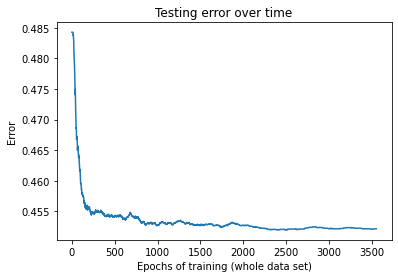

In [48]:
# we need to make a graph of this

import matplotlib.pyplot as plt

plt.plot(range(len(errors)), errors)
plt.xlabel('Epochs of training (whole data set)')
plt.ylabel('Error')
plt.title('Testing error over time')
plt.savefig('model1perf.jpg')
plt.show()



# ANN Analysis

I am going to build a 9-10-10-1 fully connected network with a basic sigmoid activation function.

In [135]:
# first let's make the activation function for simplicity sake
def activate(x):
    return 1 / (1 + np.exp(-1 * x)) 

def active_grad(x):
    return np.exp(-1 * x) / (1 + np.exp(-1 * x)) ** 2

In [136]:
# we need to prepare our data to be run through the network in the correct shape
nt_labels = train_labels.reshape(len(train_labels), 1)
nt_features = train_features
print(nt_features)
print(nt_labels)

[[0.49420331 0.58369711 0.55093786 ... 0.46858582 0.4899978  0.47202463]
 [0.46292652 0.37304276 0.62724563 ... 0.47236457 0.5239749  0.45200056]
 [0.45098687 0.41837307 0.60661045 ... 0.40238183 0.46157213 0.42498836]
 ...
 [0.47999593 0.39616514 0.48014235 ... 0.3357062  0.44270399 0.51367435]
 [0.51059909 0.4223003  0.43497771 ... 0.61016178 0.52216708 0.64601989]
 [0.45259873 0.44015791 0.50073155 ... 0.45841361 0.466105   0.46836553]]
[[0.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]


In [187]:
# we'll also select a starting seed
# np.random.seed(2022)

# now we should initialize our neurons in our layers
layer1 = 2 * np.random.random((9, 10)) - 1 
layer2 = 2 * np.random.random((10, 10)) - 1
layer3 = 2 * np.random.random((10, 1)) - 1

# I will write a function that trains for a set number of epochs
def train_epochs(num_epochs, alpha, layer1, layer2, layer3, features, labels, printfreq=10):
    
    for e in range(num_epochs):
        l0 = features
        l1 = activate(np.dot(l0, layer1))
        l2 = activate(np.dot(l1, layer2))
        l3 = activate(np.dot(l2, layer3))

        if e % printfreq == 0:
            l3_error = labels - l3 

            # we should print our current training error every once in awhile
            print("Epoch {:d} Error:{:2.4f}%".format(e, np.mean(np.abs(l3_error)) * 100))

        # let's go through and backpropagate

        l3_grad = l3_error * active_grad(l3)
        
        l2_error = l3_grad.dot(layer3.T)

        l2_grad = l2_error * active_grad(l2)

        l1_error = l2_grad.dot(layer2.T)

        l1_grad = l1_error * active_grad(l1)

        # now we want to update our weights
        layer3 = layer3 + alpha * l2.T.dot(l3_grad)
        layer2 = layer2 + alpha * l1.T.dot(l2_grad)
        layer1 = layer1 + alpha * l0.T.dot(l1_grad)


In [188]:
train_epochs(8000, .0001, layer1, layer2, layer3, nt_features, nt_labels, printfreq=10)

Epoch 0 Error:50.5623%
Epoch 10 Error:48.2421%
Epoch 20 Error:51.7579%
Epoch 30 Error:48.2423%
Epoch 40 Error:51.7577%


KeyboardInterrupt: 

In [183]:
# let's check our test error
ntest_labels = test_labels.reshape(len(test_labels), 1)
ntest_features = test_features

l0 = ntest_features
l1 = activate(np.dot(l0, layer1))
l2 = activate(np.dot(l1, layer2))
l3 = activate(np.dot(l2, layer3))

errors = ntest_labels - l3
total_error = np.mean(np.abs(errors))
print('Test Error: {:2.4f}%'.format(total_error * 100))

Test Error: 48.9585%
